In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc
from sklearn.model_selection import train_test_split
from scripts.proj1_helpers import create_csv_submission, load_csv_data

seed = 9
np.random.seed(seed)

# Preprocessing

### The very first step in every data science pipeleine is loading the date and spliting on the train/val/test holdouts

In [2]:
with open("data/test.csv", "r") as f:
    columns = f.readline().split(",")[2:]

y_test, X_test, ids_test = load_csv_data('data/test.csv')
y_dev, X_dev, ids_dev = load_csv_data('data/train.csv')

### We will split `dev` dataset on train and validation datasets with ratio 80 : 20 respectively.
Starting by directly separating the data we will work on into distinct training and validation sets limits from the start the risk of creating dependencies bewteen the sets and therefore influencing our validation set to a much higher accuracy than what we should expect. Keeping separate the transformations done on the training and validation sets avoids us from no longer accurately measuring how well our models generalize to new data found in the validation set. Categorical variables will have a binary outcome of 0 or 1.

In [3]:
ratio = 0.8
num_row = X_dev.shape[0]
indices = np.random.permutation(num_row)
    
index_split = int(np.floor(ratio * num_row))
index_train = indices[: index_split]
index_val = indices[index_split:]

# split
y_train, X_train, ids_train = y_dev[index_train], X_dev[index_train], ids_dev[index_train]
y_val, X_val, ids_val = y_dev[index_val], X_dev[index_val], ids_dev[index_val]

### Check if we need to drop some raws from dev set sincd thay are identical

In [4]:
def unique_rows(a):
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

np.all(X_dev.shape == unique_rows(X_dev).shape)

True

### Next we will plot the distributions of features of dataset :
Visualizing the data is important to gives us an idea of how it should be used, pinpointing the right direction to take and helps us analyzing it. Visualising certain columns within the data assists us to further understand the meaning of each feature, whether it is categorical or continuous and if a variable is independant or not.

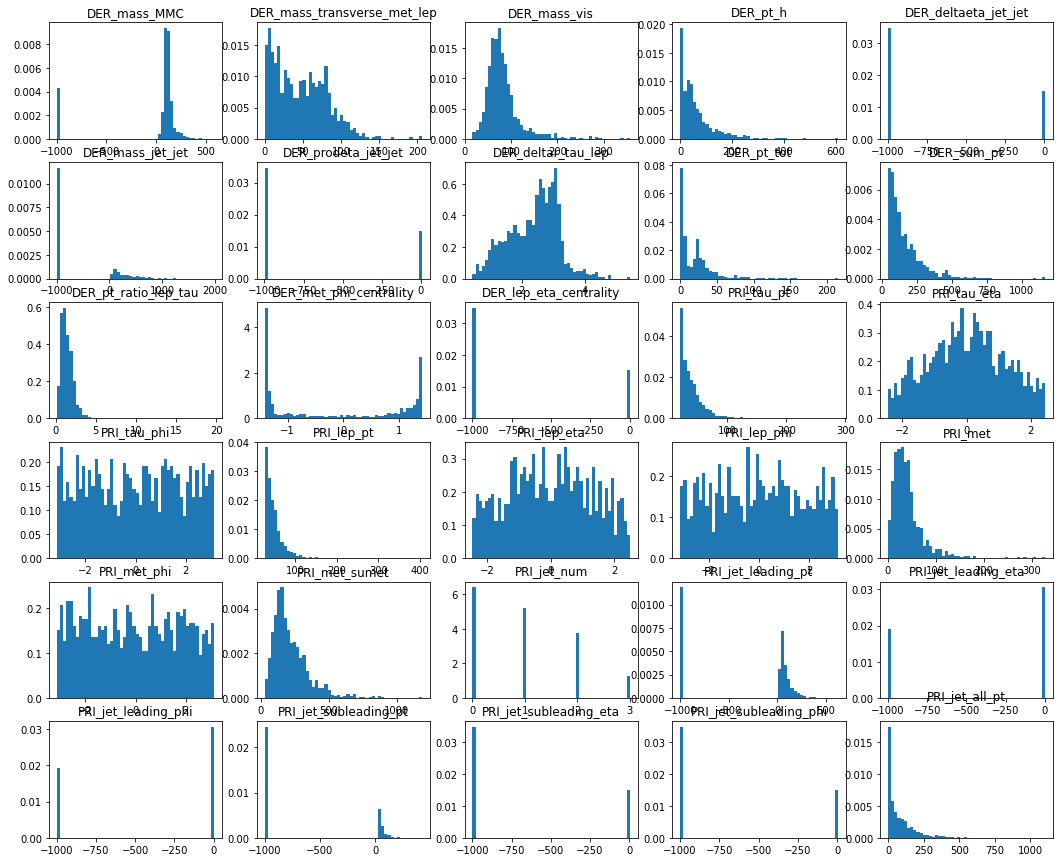

In [5]:
fig, axs = plt.subplots(6, 5, figsize=(18,15))
for i in range(X_train.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_train[:1000, i],
        bins=50, 
        density=True, 
    )
    ax.set_title(columns[i])

### Next, we will build a correlation matrix of the features to determine if we have a correlated features.
We will plot the data's correlation matrix to identify highly correlated features. The correlation measures the association between two variables, when features are highly correlated, the variance of the weight matrix will be large, which isn't beneficial for prediction due to overfitting. Therefore, we must remove highly correlated features and only keep one of the two. We used a threshold value of 0.95, all the correlation values over 0.95 or under -0.95 will be removed.

<AxesSubplot:>

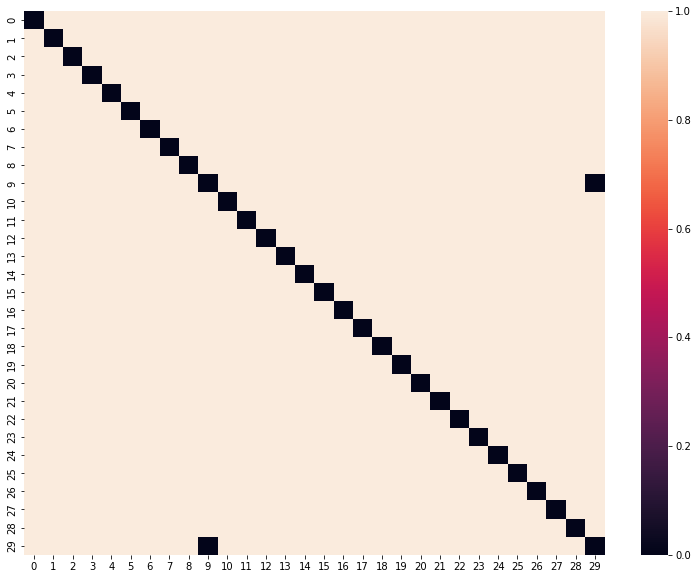

In [6]:
X_train_for_corr = np.where(X_train < -998.0, np.nan, X_train)
corr_matrix = pd.DataFrame(X_train_for_corr).corr().values
plt.figure(figsize=(13, 10))
sns.heatmap((corr_matrix < 0.95) & (-0.95 < corr_matrix))

There are only few highly correlated features, we can delete one of the two correlated features in our training, validation and test sets.

In [7]:
cor_features_ids = [pair for pair in np.argwhere((corr_matrix >= 0.95) | (-0.95 >= corr_matrix)) if pair[0] != pair[1]][::2]

In [8]:
ids_to_delete = [pair[0] for pair in cor_features_ids]
X_train = np.delete(X_train, ids_to_delete, axis=1)
X_val = np.delete(X_val, ids_to_delete, axis=1)
X_test = np.delete(X_test, ids_to_delete, axis=1)

### Getting rid of NAN values
As we can see from the histogram plots, many features contain -1000 values. These values, being much smaller than other points, can be interpreted as outliers. Outliers distort the trained models and strongly increase their variability, which should be avoided to have a better performance when we use our model on another data set. We will therefore replace them with the average value of the corresponding feature.

In [9]:
for i in range(X_train.shape[1]):
    features = X_train[:, i]
    mean = features[features >= -998.0].mean()
    X_train[:, i] = np.where(X_train[:, i] < -990.0, mean, X_train[:, i])
    X_val[:, i] = np.where(X_val[:, i] < -990.0, mean, X_val[:, i])
    X_test[:, i] = np.where(X_test[:, i] < -990.0, mean, X_test[:, i])

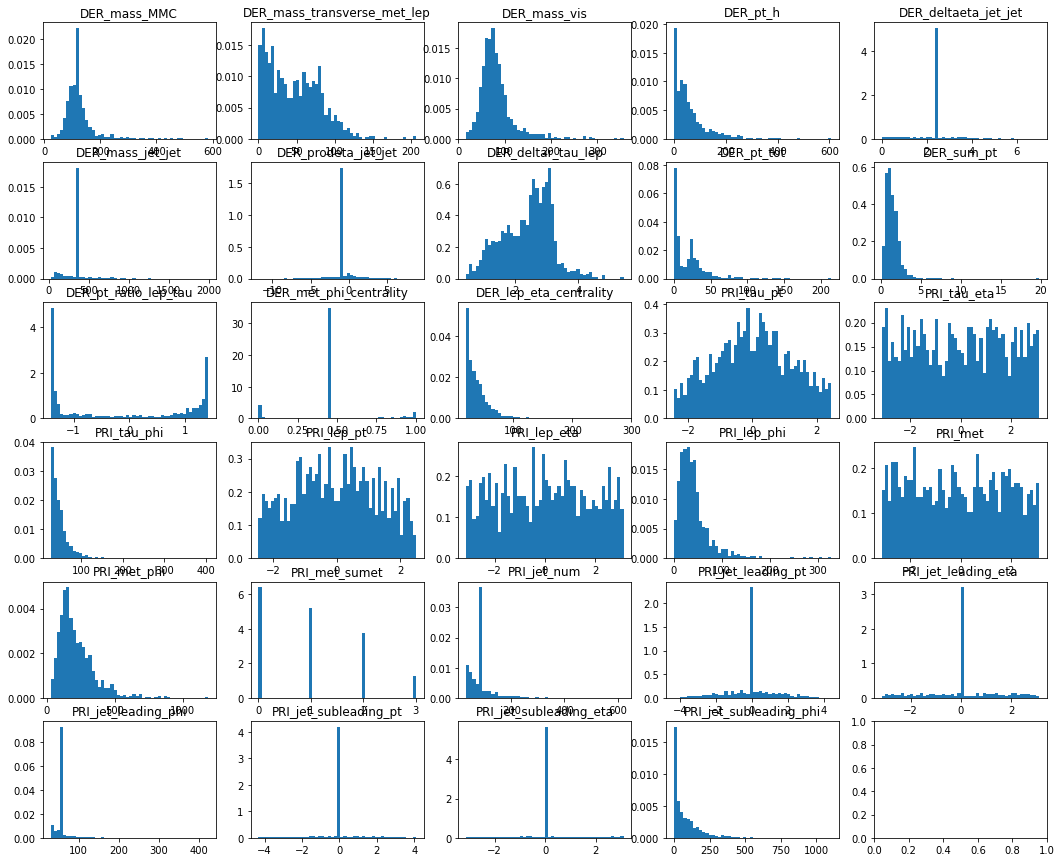

In [10]:
fig, axs = plt.subplots(6, 5, figsize=(18,15))
for i in range(X_train.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_train[:1000, i],
        bins=50, 
        density=True, 
    )
    ax.set_title(columns[i])

### Since we plan to use the logistic regression method lets chack how feature correlates with taget

Feature engineering uses knowledge and the plots to select and transform the most relevant variables from raw data to create new features that fit better the machine learning algorithm to improve its performance. Our goal is to find an effective and reliable predictive relationship between an available set of features and an outcome, a way to do this is to transform and optimize our features to the method used. Feature engineering helps uncover hidden patterns in the data to boost the predictive power of machine learning.

<AxesSubplot:>

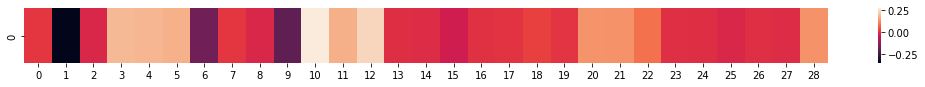

In [11]:
X_train_normalized = X_train / np.linalg.norm(X_train)
y_train_normalized = y_train / np.linalg.norm(y_train)
features = np.concatenate([X_train_normalized, y_train_normalized.reshape(-1, 1)], axis=-1)
corr_matrix_old = np.corrcoef(features.T)
plt.figure(figsize=(18, 1))
sns.heatmap(corr_matrix_old[-1, :-1].reshape(1, -1))

### Next we will transform features usin log transfromation to obtain features more correlated with the target

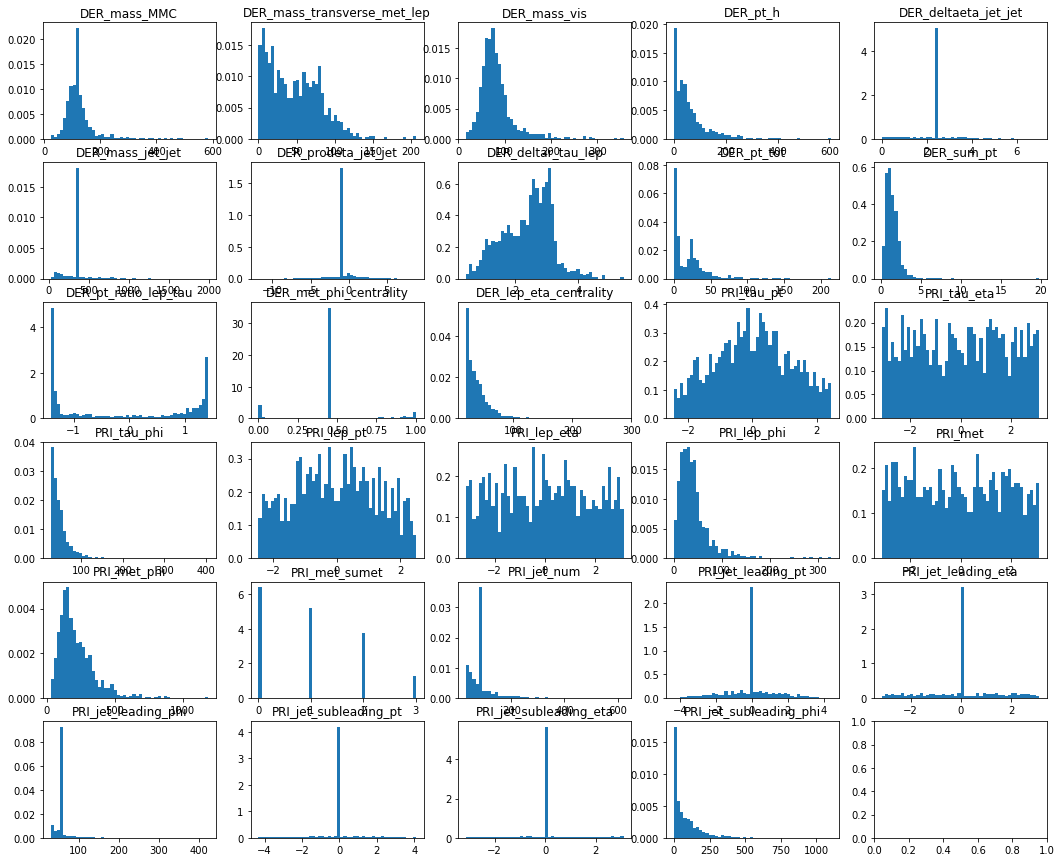

In [12]:
fig, axs = plt.subplots(6, 5, figsize=(18,15))
for i in range(X_train.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_train[:1000, i],
        bins=50, 
        density=True, 
    )
    ax.set_title(columns[i])

In [13]:
for i in [
    3, 8, 9, 12, 15, 18, 25, 28
]:
    X_train[:, i] = np.log(X_train[:, i] -  X_train[:, i].min() + 0.000001)
    X_val[:, i] = np.log(X_val[:, i] -  X_val[:, i].min() + 0.000001)
    X_test[:, i] = np.log(X_test[:, i] -  X_test[:, i].min() + 0.000001)

<AxesSubplot:>

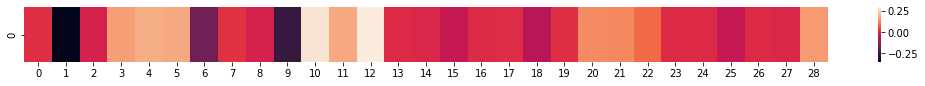

In [14]:
X_train_normalized = X_train / np.linalg.norm(X_train)
y_train_normalized = y_train / np.linalg.norm(y_train)
features = np.concatenate([X_train_normalized, y_train_normalized.reshape(-1, 1)], axis=-1)
corr_matrix = np.corrcoef(features.T)
plt.figure(figsize=(18, 1))
sns.heatmap(corr_matrix[-1, :-1].reshape(1, -1))

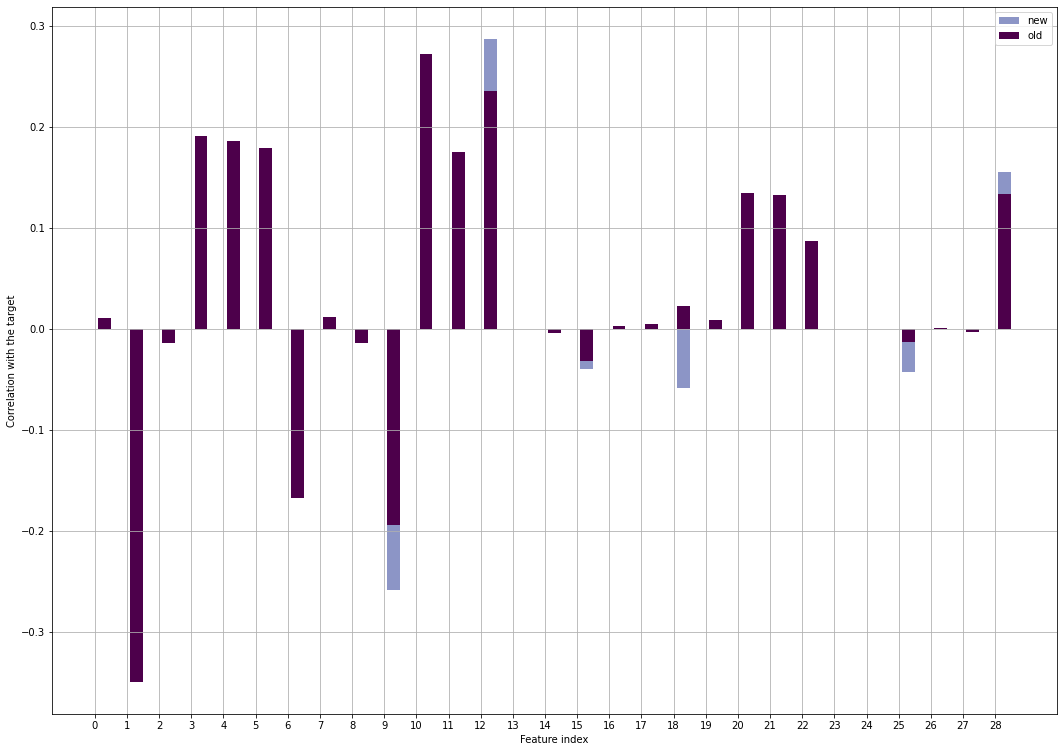

In [15]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(18,13))

data = np.stack([corr_matrix_old[-1, :-1], corr_matrix[-1, :-1]], axis=0)
values = np.arange(0, 1.0, 100)

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0.5, 1.0, data.shape[0]))
n_rows = len(data)

index = np.arange(data.shape[-1]) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(data.shape[-1])

# Plot bars and create text labels for the table
cell_text = []

plt.bar(index, data[1], bar_width, color=colors[0], label="new")
y_offset = y_offset + data[0]
plt.bar(index, data[0], bar_width, color=colors[1], label="old")
y_offset = y_offset + data[1]

plt.legend()
plt.grid()

plt.ylabel("Correlation with the target")
plt.xlabel("Feature index")
plt.xticks(np.arange(data.shape[-1]))

plt.show()

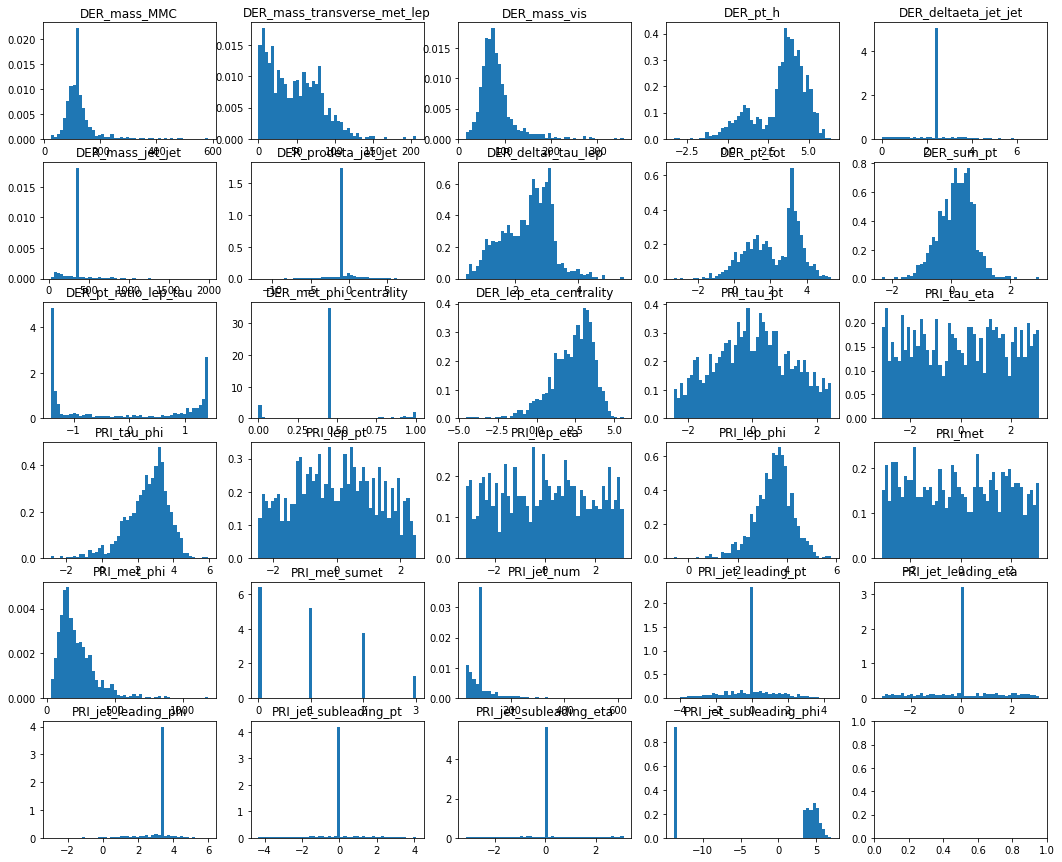

In [16]:
fig, axs = plt.subplots(6, 5, figsize=(18,15))
for i in range(X_train.shape[1]):
    ax = axs[i // 5, i % 5]
    ax.hist(
        X_train[:1000, i],
        bins=50, 
        density=True, 
    )
    ax.set_title(columns[i])

### Next thing we can observe is that `PRI_met_sumet` is a cathegorial feature, having 4 distinct values. In this regard we create 4 features from it

In [17]:
X_train_categorial = X_train[:, 21]
X_train_new_features = np.zeros((X_train.shape[0], 4))
X_train = np.delete(X_train, 21, axis=1)

X_val_categorial = X_val[:, 21]
X_val_new_features = np.zeros((X_val.shape[0], 4))
X_val = np.delete(X_val, 21, axis=1)

X_test_categorial = X_test[:, 21]
X_test_new_features = np.zeros((X_test.shape[0], 4))
X_test = np.delete(X_test, 21, axis=1)

for i in range(4):
    X_train_new_features[:, i] = np.where(X_train_categorial == i, 1, 0)
    X_val_new_features[:, i] = np.where(X_val_categorial == i, 1, 0)
    X_test_new_features[:, i] = np.where(X_test_categorial == i, 1, 0)
    
X_train = np.concatenate([X_train, X_train_new_features], axis=-1)
X_val = np.concatenate([X_val, X_val_new_features], axis=-1)
X_test = np.concatenate([X_test, X_test_new_features], axis=-1)

### And the final step of the preprocessing is to add the bias term to the X

In [18]:
X_train = np.concatenate([X_train, np.ones(X_train.shape[0]).reshape(-1, 1)], axis=-1)
X_val = np.concatenate([X_val, np.ones(X_val.shape[0]).reshape(-1, 1)], axis=-1)
X_test = np.concatenate([X_test, np.ones(X_test.shape[0]).reshape(-1, 1)], axis=-1)

# Model predictions

In [72]:
from implementations import ridge_regression, logistic_regression

In [73]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

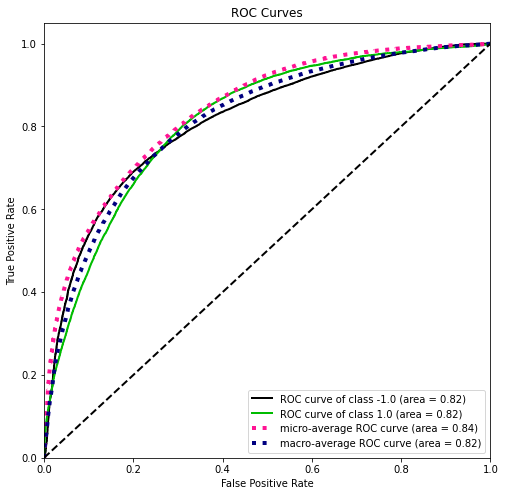

In [77]:
loss, w_pure = ridge_regression(y_train, X_train, lambda_=0.0005)
y_pred = (sigmoid(X_val @ w_pure)).reshape(-1, 1)
plot_roc(y_val, np.concatenate([1 - y_pred, y_pred], axis=1), figsize=(8,8))

In [80]:
y_pred > 0.5

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [52]:
OUTPUT_PATH = 'baseline.csv'
y_pred = np.sigX_test @ w_pure
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

<AxesSubplot:title={'center':'PCA Component Explained Variances'}, xlabel='First n principal components', ylabel='Explained variance ratio of first n components'>

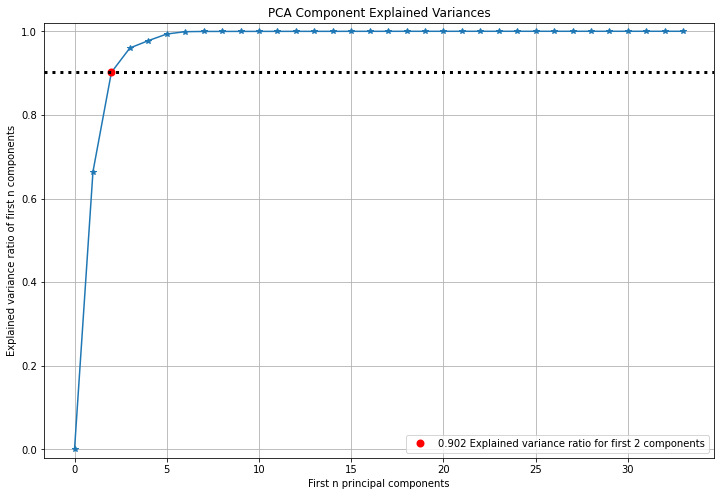

In [27]:
from sklearn.decomposition import PCA
from scikitplot.decomposition import plot_pca_component_variance
pca = PCA(random_state=1)
pca.fit(X_train)
plot_pca_component_variance(pca, figsize=(12,8))

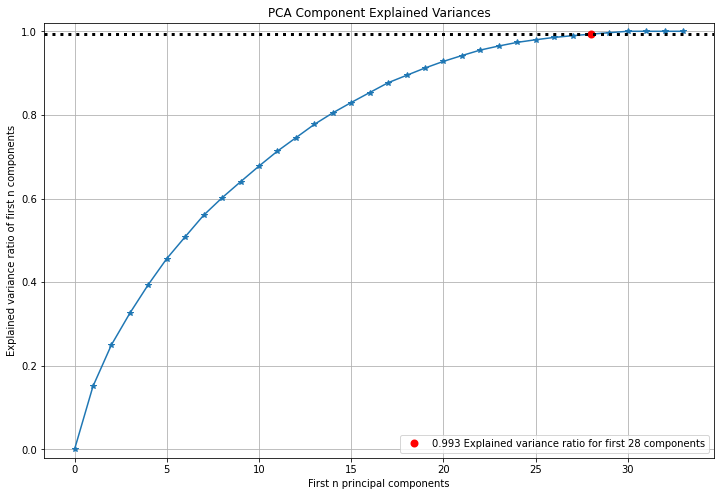

In [28]:
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler

pca = PCA(random_state=1)
preproc = StandardScaler()
preproc.fit(X_train)
pca.fit(preproc.transform(X_train))
plot_pca_component_variance(pca, figsize=(12,8), target_explained_variance=0.99)
ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = np.where(ratio == ratio[ratio > 0.99][0])[0][0] + 1

In [38]:
pca = PCA(random_state=1, n_components=2)
preproc = StandardScaler()
preproc.fit(X_train)
pca.fit(preproc.transform(X_train))
X_pca = pca.transform(preproc.transform(X_train))[::100, :]
y_pca = y_train[::100]

In [39]:
v2c = {
    1: "red",
    -1: "blue"
}

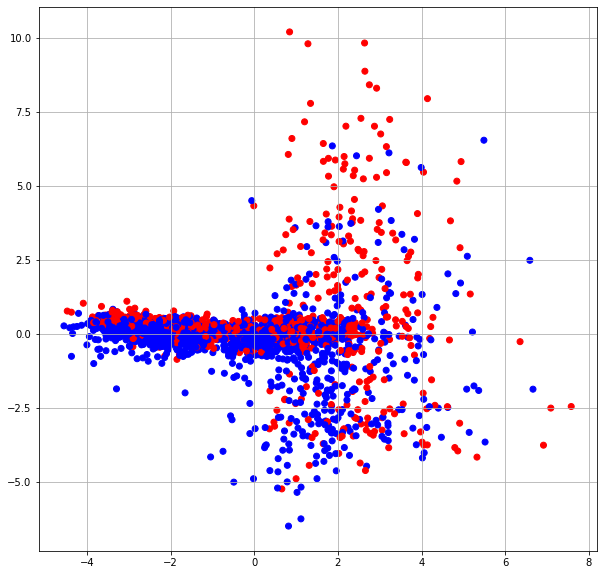

In [40]:
plt.figure(figsize=(10, 10))
plt.grid()
plt.scatter(X_pca[:,0], X_pca[:,1], c=[v2c[y_] for y_ in y_pca.reshape(-1)])
plt.show()

In [41]:
def pca(X, n_components: int):
    mean = np.mean(X, axis=0)
    sigma = np.cov(X)
    values, components = np.linalg.eig(V)
    transformed = vectors.T @ X
    return transformed, vectors, values


In [ ]:
OUTPUT_PATH = '.' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w_pure, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)